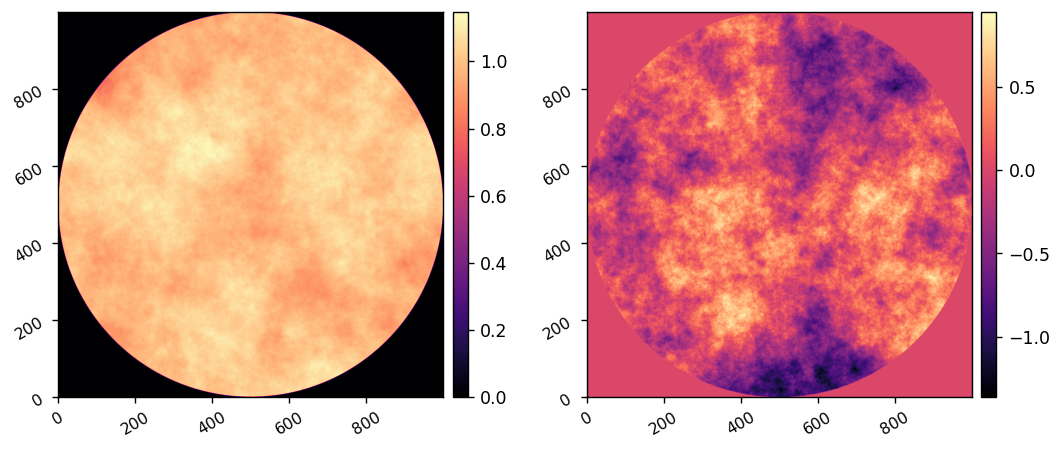

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


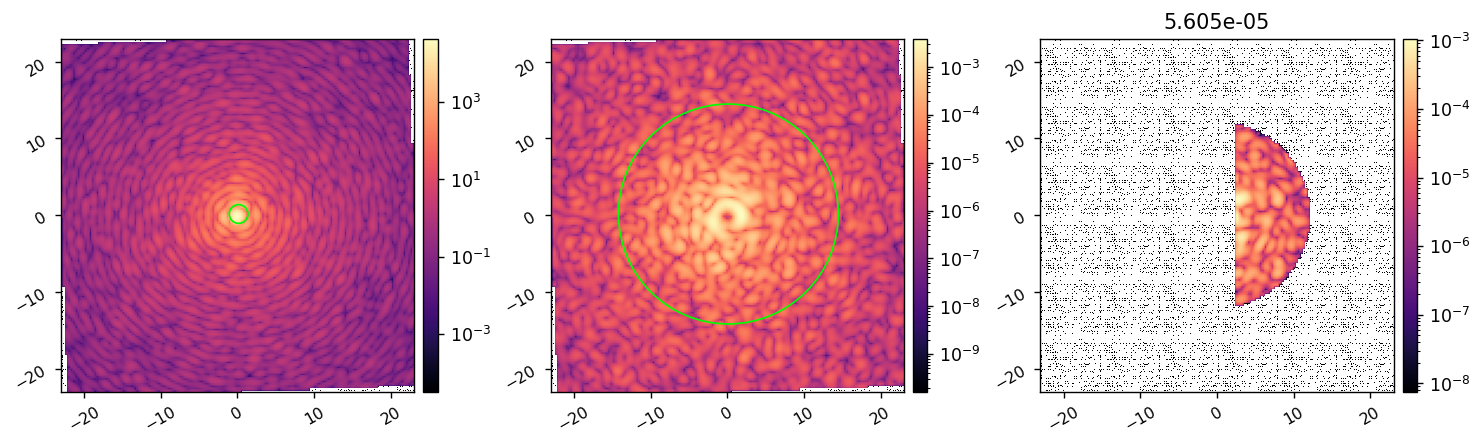

In [3]:
reload(rmad)
I = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    lyot_shift=np.array([0,0.3])*u.mm,
)
I.WFE = WFE

I.reverse_lyot = 1
I.flip_lyot = 1
I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamD/2, I.psf_pixelscale_lamD/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')])


Oversampling > 2x suggested for reliable results in Fresnel propagation.


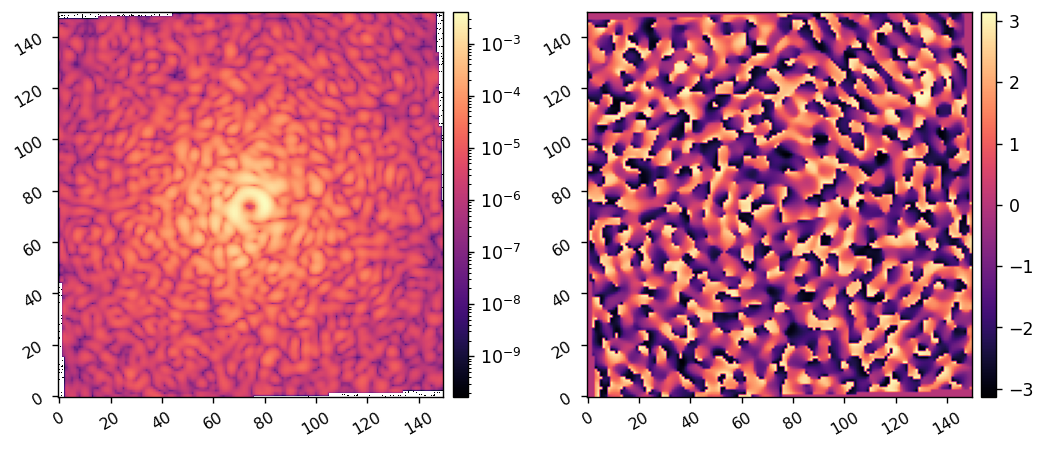

In [5]:
reload(rmad)
reload(scoobpsf.dm)
M = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    lyot_shift=np.array([0,0.3])*u.mm,
)
M.WFE = WFE

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

fpwf = M.forward(xp.zeros(M.dm_shape)[M.dm_mask], use_vortex=True)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), lognorm1=True)



In [11]:
I.zero_dm()
all_ims = []
all_efs = []
all_commands = []


In [130]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamD,
    'control_mask':control_mask, 

}

Running estimation algorithm ...
Computing EFC command with L-BFGS


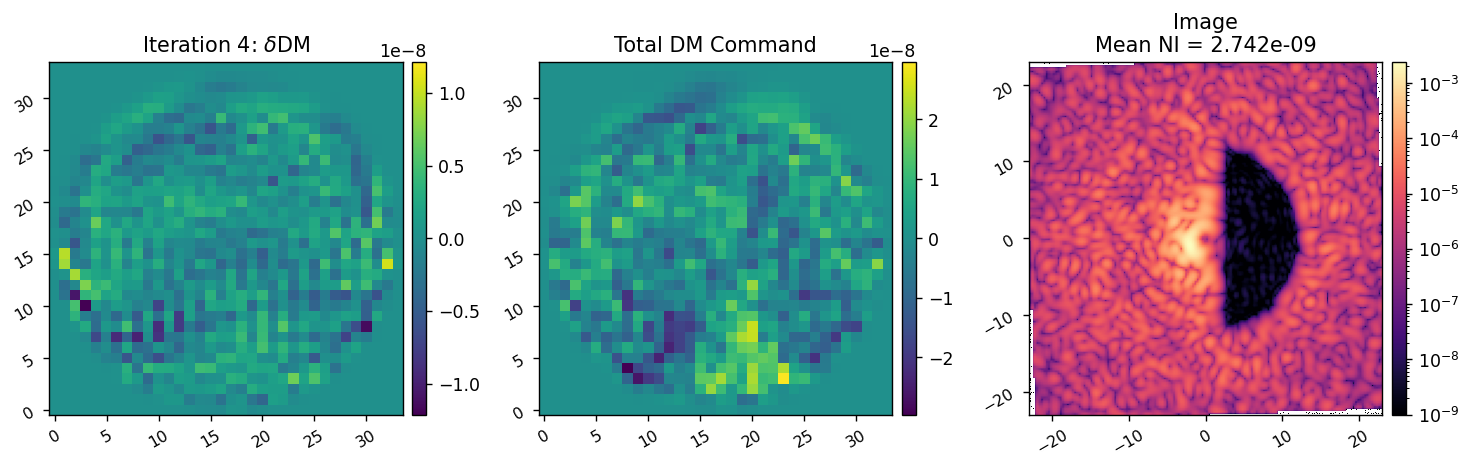

Running estimation algorithm ...
Computing EFC command with L-BFGS


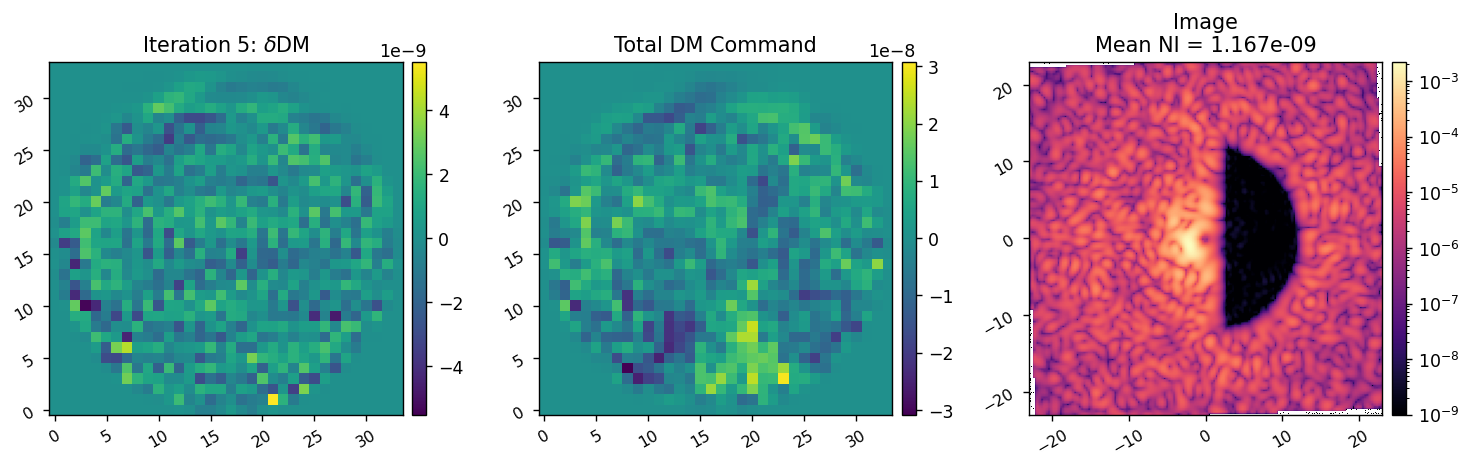

Running estimation algorithm ...
Computing EFC command with L-BFGS


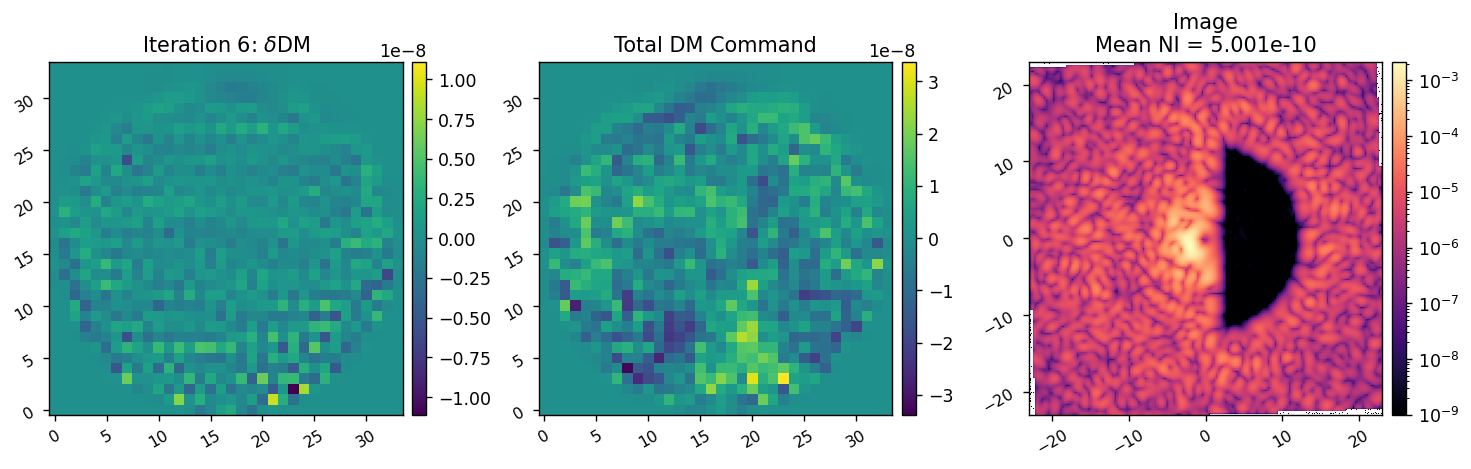

In [132]:
reload(rmad)
reload(adefc)
reload(lina.utils)

r_cond = 1e-1
r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(I, M, 
                rmad.val_and_grad, 
                control_mask, 
                data,
                Nitr=3, 
                reg_cond=r_cond,
                bfgs_tol=bfgs_tol,
                bfgs_opts=bfgs_opts,
                gain=1,
                )

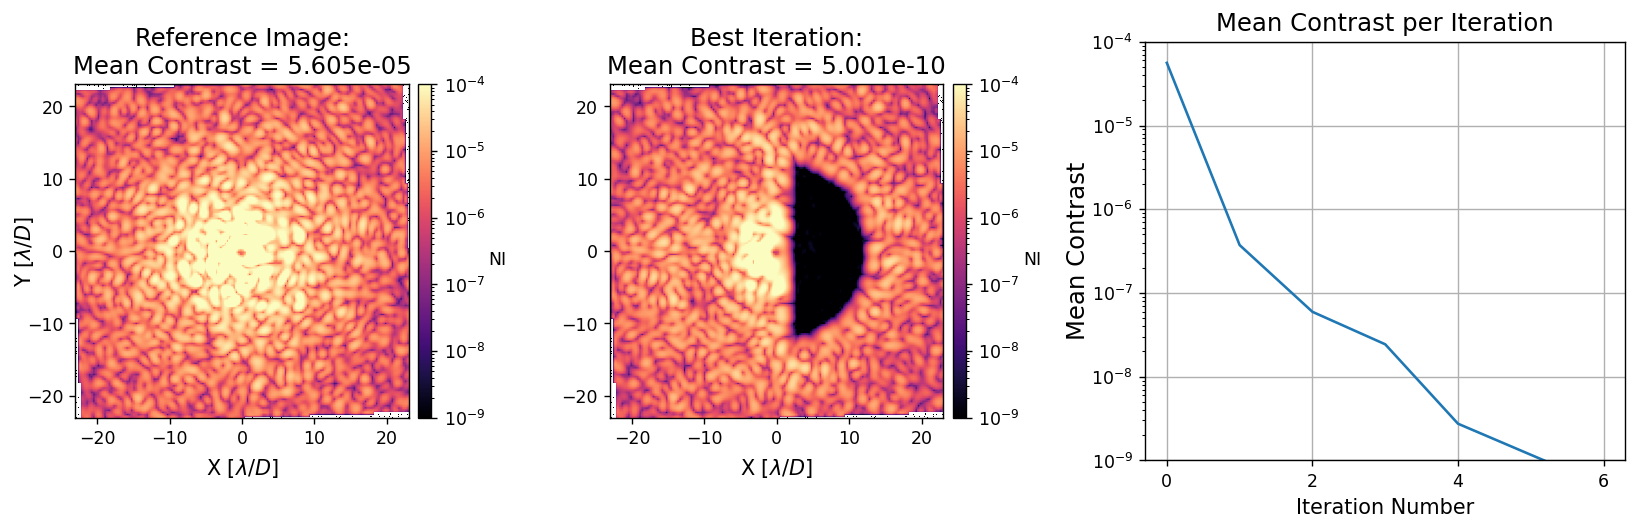

In [137]:

reload(adefc)
adefc.plot_data(data)
